In [1]:
# A CNN using torch to classify animals 
import kagglehub

# Download latest version
# You need a Kaggle API key to download datasets (ask Tom)
path = kagglehub.dataset_download("iamsouravbanerjee/animal-image-dataset-90-different-animals")

# Path to dataset files not properly configured, add to fix
path = path + "/animals/animals/"
print("Path to dataset files:", path)

/Users/tomsmail/Documents/Hackathons/DurHack2024/venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


Path to dataset files: /Users/tomsmail/.cache/kagglehub/datasets/iamsouravbanerjee/animal-image-dataset-90-different-animals/versions/5/animals/animals/


In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from torchvision.models import mobilenet_v2

import matplotlib.pyplot as plt

In [3]:
# Define transformations for the training data and testing data
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor()
])

# Load the dataset
dataset = torchvision.datasets.ImageFolder(root=path, transform=transform)

# Split the dataset into training, validation and  testing sets
train_size, val_size, test_size = int(0.8 * len(dataset)), int(0.1 * len(dataset)), int(0.1 * len(dataset))
train_set, val_set, test_set = torch.utils.data.random_split(dataset, [train_size, val_size, test_size])

# Create a DataLoader
train_loader = DataLoader(train_set, batch_size=32, shuffle=True)

print(dataset.class_to_idx)
# for i, (batch, batch_targets) in enumerate(train_loader):
#     print(batch_targets)


# Don't shuffle the validation and testing data - no point
val_loader = DataLoader(val_set, batch_size=32, shuffle=False)
test_loader = DataLoader(test_set, batch_size=32, shuffle=False)

# Print the number of batches
print(f"Number of train batches: {len(train_loader)}")
print(f"Number of validation batches: {len(val_loader)}")
print(f"Number of test batches: {len(test_loader)}")

{'antelope': 0, 'badger': 1, 'bat': 2, 'bear': 3, 'bee': 4, 'beetle': 5, 'bison': 6, 'boar': 7, 'butterfly': 8, 'cat': 9, 'caterpillar': 10, 'chimpanzee': 11, 'cockroach': 12, 'cow': 13, 'coyote': 14, 'crab': 15, 'crow': 16, 'deer': 17, 'dog': 18, 'dolphin': 19, 'donkey': 20, 'dragonfly': 21, 'duck': 22, 'eagle': 23, 'elephant': 24, 'flamingo': 25, 'fly': 26, 'fox': 27, 'goat': 28, 'goldfish': 29, 'goose': 30, 'gorilla': 31, 'grasshopper': 32, 'hamster': 33, 'hare': 34, 'hedgehog': 35, 'hippopotamus': 36, 'hornbill': 37, 'horse': 38, 'hummingbird': 39, 'hyena': 40, 'jellyfish': 41, 'kangaroo': 42, 'koala': 43, 'ladybugs': 44, 'leopard': 45, 'lion': 46, 'lizard': 47, 'lobster': 48, 'mosquito': 49, 'moth': 50, 'mouse': 51, 'octopus': 52, 'okapi': 53, 'orangutan': 54, 'otter': 55, 'owl': 56, 'ox': 57, 'oyster': 58, 'panda': 59, 'parrot': 60, 'pelecaniformes': 61, 'penguin': 62, 'pig': 63, 'pigeon': 64, 'porcupine': 65, 'possum': 66, 'raccoon': 67, 'rat': 68, 'reindeer': 69, 'rhinoceros': 

/Users/tomsmail/Documents/Hackathons/DurHack2024/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/Users/tomsmail/Documents/Hackathons/DurHack2024/venv/lib/python3.12/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V2_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V2_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


Epoch [1/5], Loss: 2.5972
Epoch [2/5], Loss: 1.7032
Epoch [3/5], Loss: 0.9821
Epoch [4/5], Loss: 0.6132
Epoch [5/5], Loss: 0.7996


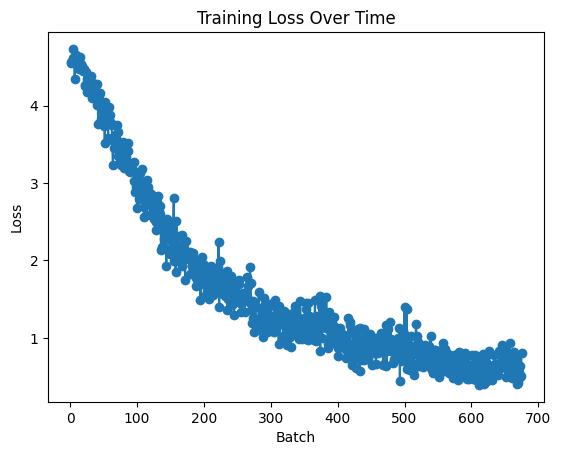

In [4]:
# Load the pre-trained MobileNet model
model = mobilenet_v2(pretrained=True)

# Freeze all the layers
for param in model.parameters():
    param.requires_grad = False

num_classes = 90
model.classifier[1] = nn.Linear(model.classifier[1].in_features, num_classes)

# Unfreeze the last few layers for fine-tuning
for param in model.features[-5:].parameters():
    param.requires_grad = True

# Print the model architecture to verify
# print(model)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()

# Define the optimizer with momentum
optimizer = optim.SGD(filter(lambda p: p.requires_grad, model.parameters()), lr=0.001, momentum=0.9)


loss_values = []

# Example training loop
num_epochs = 5
for epoch in range(num_epochs):
    model.train()
    for images, labels in train_loader:
        outputs = model(images)
        loss = criterion(outputs, labels)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        loss_values.append(loss.item())

    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {loss.item():.4f}")

plt.plot(range(1, len(loss_values) + 1), loss_values, marker='o')
plt.xlabel('Batch')
plt.ylabel('Loss')
plt.title('Training Loss Over Time')
plt.show()

In [5]:
# Model evaluation
model.eval()
tp_tn_fp_fn = torch.zeros(4, num_classes)
with torch.no_grad():
    correct = 0
    total = 0
    for images, labels in test_loader:
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        print(predicted)
        correct += (predicted == labels).sum().item()

    print(f"Validation accuracy: {(100 * correct / total):.4f}%")


tensor([ 0, 31, 54, 45, 51, 69, 62, 56,  8, 80, 48,  2, 18,  9, 30, 61,  6, 86,
        34, 11, 27, 28, 52, 44, 24, 71, 11, 48, 43, 26, 61, 67])
tensor([38, 85, 87, 75, 77, 62, 64, 48, 47,  9, 50, 49,  3, 58, 29,  6, 28, 46,
        52,  5,  7, 34, 86, 28, 29, 15, 12, 28, 78, 43, 37, 34])
tensor([13, 22, 72, 54, 64, 37, 43, 65, 24, 39, 38,  6,  4, 16, 42, 64, 31, 22,
        27,  9, 44, 56, 43, 39, 40,  2, 41, 64, 10, 63, 33, 76])
tensor([ 6, 87, 34, 31, 51, 84, 59,  9, 53, 20, 45, 76,  3, 17, 49, 38,  8, 59,
        83, 77, 35, 42, 37, 10, 28, 69,  8, 39, 47, 73, 83, 75])
tensor([ 7, 89, 24, 44, 76, 28, 56, 25, 67, 20, 49, 39, 35, 55, 84, 71, 85, 58,
        15, 85,  7, 29, 80, 28, 46,  4, 22, 59,  1, 55, 89,  2])
tensor([48,  5, 12, 29, 59, 86, 57, 19, 87, 38, 24, 34, 31, 46, 58, 24, 14,  6,
        13, 43, 19, 87,  0, 55, 79, 44, 31, 50, 39, 23, 34, 23])
tensor([69, 66, 73, 52, 12, 81, 80, 43, 72, 75, 45, 76, 64, 74, 35, 35, 39, 41,
        52, 68, 29, 89, 71,  8,  0, 47, 79, 15, 51

In [ ]:
# Save the model to disk
# torch.save(model.state_dict(), "animal_model.pth")